# Reorder Point Determination
Prepared by: Nickolas Freeman, PhD

In this notebook we will consider the problem of determining reorder points for a set of purchased products that are subject to demand and lead time uncertainty. This is a common problem in inventory management that is faced by companies in a wide range of industries. Due to its practical relevance, this problem has been extensively studied. However, most research focuses on determining the structure of the optimal ordering policy, not necessarily providing results that are easily implemeted by practitioners. We will use monte carlo simulation techniques to simulate product demands during the replenishment lead time. The simulation will provide a vector of observations, each of which represents a potential scenario for demand during the lead time. We will then identify percentiles of the scenarios for demand during the lead time that correspond to user-selected service levels in order to determine the inventory position (on-hand + in-transit) level that should be used to trigger reorders.

The following code block imports the libraries we will use.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import distribution_fitting as dist_fit
import datetime

The following code block imports two data files that we will use and store them in Pandas `DataFrame` objects. The `lt_data` object includes order and delivery dates for the various products. The `demand_data` object includes daily sales for the products.

In [2]:
lt_data = pd.read_csv('LT_Data.csv')
demand_data = pd.read_csv('demand_data.csv')

The `lt_data` object includes information on the order and delivery dates for 100 products. The number of observations varies by product. The following code block prints the first five rows.

In [3]:
lt_data.head()

,Product,Order_Date,Delivery_Date
0,TQO7U9,2016-01-01 00:01:00,2016-01-13 03:01:00
1,2IGA7Y,2016-01-01 03:01:00,2016-02-02 12:02:00
2,2XAMNE,2016-01-01 17:01:00,2016-01-21 19:01:00
3,I0VI9X,2016-01-01 21:01:00,2016-01-08 10:01:00
4,R5ZAT7,2016-01-02 02:01:00,2016-01-18 06:01:00


The `demand_data` object includes information on the sales of the 100 products over the last 1,170 days. The following code block prints the first five rows.

In [4]:
demand_data.head()

,Date,0R25WF,10FQ8W,1A5N7S,1Q8MLE,2DS613,2IGA7Y,2MA6C6,2VWXHB,2XAMNE,...,VW3J8R,VWYZZ6,WLJHSS,WOHDY2,Y0CQ65,YE1CCF,YNLMDV,YZ3I9T,Z6UJEJ,Z9O3MV
0,2016-01-01,17.0,32.0,11.0,9.0,12.0,23.0,13.0,24.0,22.0,...,15.0,31.0,6.0,25.0,14.0,23.0,14.0,7.0,6.0,6.0
1,2016-01-02,16.0,31.0,10.0,17.0,11.0,14.0,25.0,19.0,22.0,...,31.0,24.0,7.0,18.0,20.0,19.0,16.0,10.0,18.0,4.0
2,2016-01-03,29.0,30.0,8.0,15.0,11.0,22.0,16.0,46.0,20.0,...,31.0,25.0,12.0,21.0,18.0,29.0,6.0,13.0,9.0,9.0
3,2016-01-04,6.0,30.0,10.0,6.0,11.0,24.0,25.0,31.0,22.0,...,18.0,24.0,8.0,19.0,23.0,34.0,11.0,17.0,22.0,4.0
4,2016-01-05,18.0,31.0,17.0,8.0,10.0,11.0,33.0,22.0,18.0,...,19.0,30.0,11.0,24.0,19.0,27.0,6.0,12.0,20.0,7.0


The following code block uses a for loop to define a grid of subplots that demonstrates the variety of distributions for the underlying product demands.

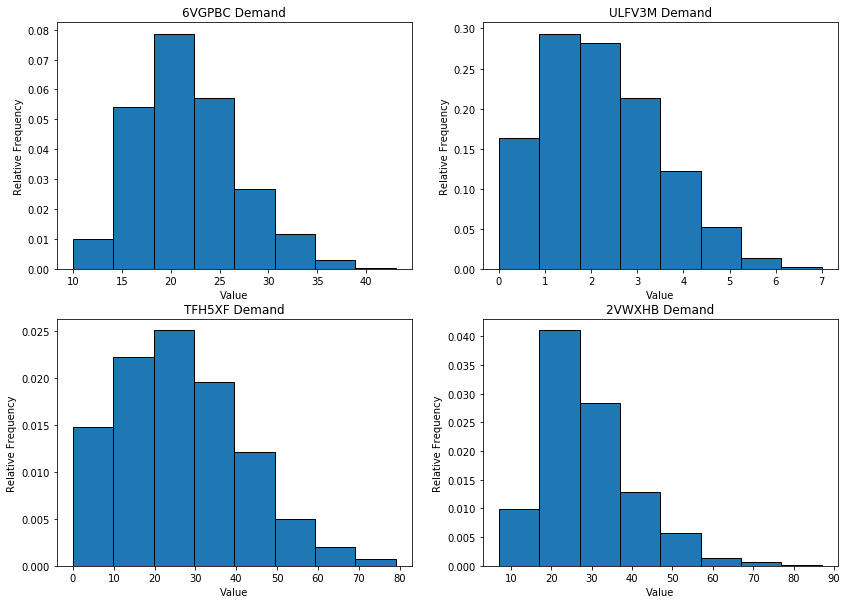

In [5]:
products_to_plot = [['6VGPBC', 'ULFV3M'],
                    ['TFH5XF','2VWXHB']]

fig, ax = plt.subplots(len(products_to_plot), 
                       len(products_to_plot[0]),
                       figsize = (14,10))

for row in range(len(products_to_plot)):
    for column in range(len(products_to_plot[0])):
        current_product = products_to_plot[row][column]
    
        ax[row,column].hist(demand_data[current_product].values, 
                            edgecolor = 'k',
                            bins = 8,
                            density = True)
        ax[row,column].set_title(f'{current_product} Demand')
        ax[row,column].set_xlabel(f'Value')
        ax[row,column].set_ylabel(f'Relative Frequency')

plt.show()

The first thing that we need to do is convert the dates given in the `lt_data` object to `datetime` objects, and use the converted data to calculate the lead time observations. The following code block performs this conversion.

In [6]:
lt_data['Order_Date'] = pd.to_datetime(lt_data['Order_Date'])
lt_data['Delivery_Date'] = pd.to_datetime(lt_data['Delivery_Date'])
lt_data['Lead_Time'] = (lt_data['Delivery_Date'] - lt_data['Order_Date']).dt.total_seconds()/(24*60*60)
lt_data.head()

,Product,Order_Date,Delivery_Date,Lead_Time
0,TQO7U9,2016-01-01 00:01:00,2016-01-13 03:01:00,12.125000
1,2IGA7Y,2016-01-01 03:01:00,2016-02-02 12:02:00,32.375694
2,2XAMNE,2016-01-01 17:01:00,2016-01-21 19:01:00,20.083333
3,I0VI9X,2016-01-01 21:01:00,2016-01-08 10:01:00,6.541667
4,R5ZAT7,2016-01-02 02:01:00,2016-01-18 06:01:00,16.166667


Since both the replenishment lead time and demand are uncertain, we will need to fit distributions so that we can generate random samples for these two variables. The following code uses the kernel density estimation techniques available in the `distribution_fitting` module to fit a distribution for the lead time of a user-specified product.

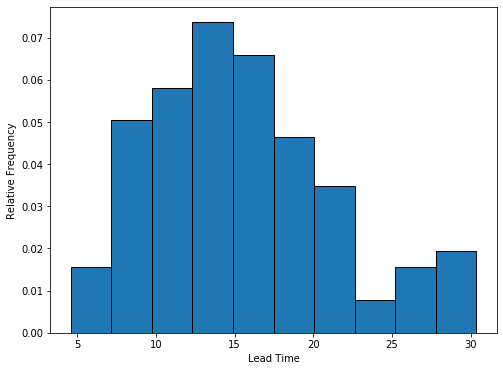

In [7]:
current_product = 'TQO7U9'
sample_size = 100

mask = lt_data['Product'] == current_product
lt_data_sample = lt_data.loc[mask, 'Lead_Time'].values
lt_best_params = dist_fit.fit_best_kde(lt_data_sample)
pdf = dist_fit.pdf_from_kde(lt_data_sample, 
                            bandwidth = lt_best_params['bandwidth'], 
                            kernel = lt_best_params['kernel'])
lt_random_sample = dist_fit.trunc_kde_sample(pdf['x'], pdf['y'], sample_size = sample_size)

fig, ax = plt.subplots(figsize = (8,6))
ax.hist(lt_random_sample, density = True, edgecolor = 'k')
ax.set_xlabel('Lead Time')
ax.set_ylabel('Relative Frequency')
plt.show()

The following code block specifes the code needed to fit a distribution for the product specified in the previous cell and generate a sample for the demand that for each day of a specified lead time. Summing up the demand values in the sample provides a single scenario for the demand during the replenishment lead time. 

In [8]:
demand_data_sample = demand_data[current_product].values
demand_best_params = dist_fit.fit_best_kde(demand_data_sample, 
                                           fit_sample_size = 400)
pdf = dist_fit.pdf_from_kde(demand_data_sample,
                            bandwidth = demand_best_params['bandwidth'], 
                            kernel = demand_best_params['kernel'])
lt_val = 10
demand_random_sample = dist_fit.trunc_kde_sample(pdf['x'], 
                                                 pdf['y'], 
                                                 sample_size = lt_val)
print(f'Demand during lead time is {np.array(demand_random_sample).sum()}')

Demand during lead time is 209.03963963963963


Together, the previous two code block provide a sense of how we will approach the problem of reorder point determination. Essentially, we will generate a random sample for the lead of each product. Then, for each scenario in the lead time sample, we will randomly generate a demand sample, where the length of the demand sample corresponds to the timeframe specified in the current scenario. Summing the demand values in the generated scenario provides one possible realization for demand during the lead time. Storing the demand during the lead time scenarios for all values of the lead time in the the lead time sample allows us to approximate the distribution for lead time demand. We can use this distribution to determine appropriate reorder point levels that guarantee user-specified serive levels. Pseudocode for the approach follows:

```python
1. define sample size and target service levels
for product in products:
    2. fit lead time distribution
    3. fit demand distribution
    4. generate lead time sample
    for each scenario in lead time sample:
        5. generate a demand sample corresponding to the number of days in the lead time sample
        6. calculate total demand, which represents a pontential observation of lead time demand
        7. store lead time demand observation
    8. use current product lead time demand information to compute reorder points for target service levels
    9. store reorder points
10. output reorder point information
```

In [9]:
# specify the sample size (i.e., the number of
# lead time values to generate)
sample_size = 1000

# specify the service level values to consider
service_levels = [95, 99]

# specify a cutoff value that will limit the number of 
# products to consider
cutoff = 3

# initialize an empty dictionary to store the 
# reorder point information
reorder_info = {}

# for each product (up to the specified cutoff)
for index, current_product in enumerate(lt_data['Product'].unique()[:cutoff]):
    reorder_info[current_product] = {}
    
    # capture the time that the simulation starts for the current product
    start = datetime.datetime.now()
    
    # initialize an empty list that will contain the demand
    # during the lead time scenarios
    demand_during_lt_list = []
    
    # fit the lead time distribution for the current product
    lt_data_sample = lt_data[lt_data['Product'] == current_product]['Lead_Time'].values
    mean_lt = lt_data_sample.mean()
    lt_best_params = dist_fit.fit_best_kde(lt_data_sample)
    lt_pdf = dist_fit.pdf_from_kde(lt_data_sample, 
                                   bandwidth = lt_best_params['bandwidth'], 
                                   kernel = lt_best_params['kernel'])

    # fit the demand distribution for the current product
    demand_data_sample = demand_data[current_product].values
    mean_demand = demand_data_sample.mean()
    demand_best_params = dist_fit.fit_best_kde(demand_data_sample, fit_sample_size = 400)
    demand_pdf = dist_fit.pdf_from_kde(demand_data_sample,
                                       bandwidth = demand_best_params['bandwidth'],
                                       kernel = demand_best_params['kernel'])
    
    # calculate the mean demand during the lead time
    mean_demand_during_LT = mean_demand * mean_lt
    
    # generate a random lead time sample
    lt_random_sample = dist_fit.trunc_kde_sample(lt_pdf['x'], lt_pdf['y'], sample_size = sample_size)
    
    # for each lead time value in the sample
    for lt_index, lt_val in enumerate(lt_random_sample):
        
        # generate a demand sample where the length of the sample 
        # equals the current value of the lead time sample
        # (rounded UP to the nearest integer)
        demand_random_sample = dist_fit.trunc_kde_sample(demand_pdf['x'],
                                                         demand_pdf['y'], 
                                                         low = 0, 
                                                         seed = lt_index,
                                                         sample_size = int(np.ceil(lt_val)))
        
        # sum the demand values and append result to lead
        # time demand list
        demand_during_lt_list.append(np.array(demand_random_sample).sum())
        
    # update reorder point array
    reorder_info[current_product]['Mean LT Demand'] = mean_demand_during_LT
    for service_level in service_levels:
        reorder_info[current_product][f'{service_level}% SL'] = np.percentile(np.array(demand_during_lt_list), 
                                                                              service_level)
    
    # capture and print the elapsed simulation time for the current product
    print(f'{current_product} complete. Total run time = {datetime.datetime.now()-start}')
    
pd.DataFrame.from_dict(reorder_info, orient = 'index')

TQO7U9 complete. Total run time = 0:00:02.362839
2IGA7Y complete. Total run time = 0:00:02.251647
2XAMNE complete. Total run time = 0:00:01.982190


,Mean LT Demand,95% SL,99% SL
TQO7U9,309.952991,534.204189,595.614000
2IGA7Y,638.639830,925.310255,1003.973237
2XAMNE,251.349095,539.363363,609.891620
